# TSFS12 Hand-in exercise 3, extra assignment: Path following for autonomous vehicles with MPC controller

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vehiclecontrol import ControllerBase, SingleTrackModel
from splinepath import SplinePath
import casadi

In [2]:
# %matplotlib  # Run if you want plots in external windows

In [3]:
# Run the ipython magic below to activate automated import of modules. Useful if you write code in external .py files.
# %load_ext autoreload
# %autoreload 2

# Make a simple controller and simulate vehicle

Simulate a sample path to follow

In [2]:
class MiniController(ControllerBase):
    def __init__(self):
        super().__init__()
    
    def u(self, t, w):
        a = 0.0
        if t < 10:
            u = [np.pi / 180 * 10, a]
        elif 10 <= t < 20:
            u = [-np.pi / 180 * 11, a]
        elif 20 <= t < 23:
            u = [-np.pi / 180 * 0, a]
        elif 23 <= t < 40:
            u = [-np.pi / 180 * 15, a]
        else:
            u = [-np.pi / 180 * 0, a]
        return u

opts = {'L': 2, 
        'amax': np.inf,
        'amin': -np.inf,
        'steer_limit': np.pi / 3}

car = SingleTrackModel().set_attributes(opts)
car.Ts = 0.1
car.controller = MiniController()
w0 = np.array([0, 0, 0, 2])
z0 = car.simulate(w0, T=40, dt=0.1, t0=0.0)
t, w, u = z0
M = 10
p = w[::M, 0:2]
nom_path = SplinePath(p)

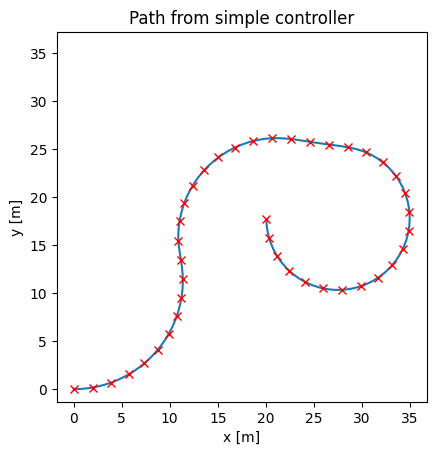

In [3]:
s = np.linspace(0, nom_path.length, 100)

_, ax = plt.subplots(num=10, clear=True)
ax.plot(nom_path.x(s), nom_path.y(s))
ax.plot(p[:, 0], p[:, 1], 'rx')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Path from simple controller')
_ = ax.axis('square')

# Make an MPC path following controller

Make a MPC controller using the template class below. Parameters for the controller are
* gamma_d - Weight in the loss-function for _distance errors_
* gamma_theta - Weight in the loss-function for _heading errors_
* gamma_u - Weight in the loss-function for _control signal_ (steer angle)
* L - wheel base
* steer_limit - Steer limits (in radians) for the control signal

Arguments to the controller is provided in a dictionary like this

In [4]:
opts = {
    'h_p': 10, # horizon measured in time [s] 
    'gamma_d': 1,
    'gamma_theta': 1,
    'gamma_u': 1,
    'L': 2,  # Nominally, use the same as in the car
    'steer_limit': np.pi / 4  # Nominally, use the same in the car
}

In [7]:
class ModelPredictiveController(ControllerBase):
    def __init__(self, controller_params, path=None, goal_tol=1, dt=0.1):
        super().__init__()
        
        self.plan = path  # SplinePath object
        self.gamma_d = controller_params['gamma_d']
        self.gamma_theta = controller_params['gamma_theta']
        self.gamma_u = controller_params['gamma_u']
        self.L = controller_params['L']  # length of the car (distance between axles)
        self.steer_limit = controller_params['steer_limit']

        self.sample_rate = dt
        self.prediction_horizon = controller_params['h_p']
        self.N = int(self.prediction_horizon / dt)  # (discrete) number of timesteps (forward) in the prediction horizon
        
        self.goal_tol = goal_tol
        self.d = []
        self.s0 = 0
        self.optimizer = self.construct_problem()

    def heading_error(self, theta, s):
        """
        Compute theta error.

        Inputs:
            theta - current heading angle
            s - projection point on path
            
        Outputs:
            theta_e - heading error angle
        """
        
        # get heading of vehicle, hv
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]])
        hv = np.matmul(rot_mat, (np.array([[1, 0]]).reshape(-1, 1)))
        hv = np.squeeze(hv)

        # get heading of path, hs
        hs, _ = self.plan.heading(s)

        # get angle between hv, hs
        cos_theta_e = np.dot(hs, hv)/(np.linalg.norm(hs) * np.linalg.norm(hv))
        hv_ext = np.hstack((hv, 0))
        hs_ext = np.hstack((hs, 0))

        cross = np.cross(hs_ext, hv_ext)/(np.linalg.norm(hs) * np.linalg.norm(hv))
        sin_theta_e = cross[2]
    
        theta_e = np.arctan2(sin_theta_e, cos_theta_e)
        return theta_e
        
    def construct_problem(self):
        """Formulate optimal control problem"""
        
        dt = self.sample_rate
        
        # Create an casadi.Opti instance.
        opti = casadi.Opti('conic')
        
        d0 = opti.parameter()
        th0 = opti.parameter()
        v = opti.parameter()
        curvature = opti.parameter(self.N)
        
        X = opti.variable(2, self.N + 1)
        proj_error = X[0, :]
        head_error = X[1, :]
        
        # Control variable (steering angle) (sequence throughout horizon)
        Delta = opti.variable(self.N) 

        # Delta and X are updated throughout the optimization process (control and state)
        # it is the sequence of control outputs that is optimized over

        # Goal function we wish to minimize   
        ### YOUR CODE HERE ###  # Exercise D.1

        # set (constant) parameter values 

        # Use the casadi.sumsqr function to compute sum-of-squares (calculates dot product of vector with itself)

        """
            I'm confused again.

            Assignnment says:
            
                "Use the CasADi function sumsqr to compute the sum-of-squares needed. 
                Also, use the heading_error function from the state-feedback controller in the basic exercise.".

            I read this as an implication to use heading_error() in this function (potential mistake).
            It is very possible that I've misunderstood completely, and that heading_error() is only supposed 
            to be called in self.u(), just like with the controllers in the basic exercise. Ignore the rest of
            this text in that case.

            Why would I use heading_error() here? The heading error in X (opti.variable) is updated using the 
            error_model() function. 

            I would need to change the way x_next is computed below. Why would I do that?
            error_model() has curvature as input in order to calculate the estimated change in the heading error.
            That would be entirely unnecessary if I were supposed to use heading_error() here.

            Furthermore, If I am to use heading_error(), I need the theta angle of the car, which isn't even 
            available within this function scope. The state variables in the optimization problem are the heading 
            error and distance error, not the heading and position of the car itself.
        """
        
        
        J = (self.gamma_d * casadi.sumsqr(proj_error) 
             + self.gamma_theta * casadi.sumsqr(head_error) 
             + self.gamma_u * casadi.sumsqr(Delta))

        opti.minimize(J)
         
        # Simulate the system forwards using 4th order Runge-Kutta and the implemented error model.
        for k in range(self.N):
            k1 = self.error_model(X[:, k], v, Delta[k], curvature[k])
            k2 = self.error_model(X[:, k] + dt / 2 * k1, v, Delta[k], curvature[k])
            k3 = self.error_model(X[:, k] + dt / 2 * k2, v, Delta[k], curvature[k])
            k4 = self.error_model(X[:, k] + dt * k3, v, Delta[k], curvature[k])
            x_next = X[:, k] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next)
        
        # Problem constraints.
        opti.subject_to(proj_error[0] == d0)
        opti.subject_to(head_error[0] == th0)
        opti.subject_to(opti.bounded(-self.steer_limit, Delta, self.steer_limit))
        
        # The cost function is quadratic and the problem is linear by design,
        # this is utilized when choosing solver.
        # Other possible solvers provided by CasADi include: 'qpoases' and 'ipopt'...

        opts_dict = {
            "print_iter": False,
            "print_time": 0,
            "constr_viol_tol": 1e-12,
            # "max_iter": 100
        }
        
        opti.solver('qrqp', opts_dict)
        
        return opti.to_function('f', [d0, th0, v, curvature], [Delta])
        
    def error_model(self, w, v, delta, curvature):
        """Error model describing how the distance and heading error evolve for a certain input
            
        Input:
            w = (d, theta_e)
            v - velocity
            delta - input, steering angle
            curvature - current curvature
            
        Output:
            Casadi vector of Time derivative of d and theta_e
        """

        # YOUR CODE HERE (Exercise D.2)

        # Linearizations:
        # s_dot ~= v  (path velocity approx. equal to car velocity)
        # sin(theta_e) ~= theta_e  (small theta_e)
        # u = tan(delta) ~= delta  (small delta)


        """
            I'm confused.

            Assignment says:

                "...Important that you ensure that the error model is linear. 
                Therefore, assume constant velocity, constant curvature...",

            but the curvature is sent in as an argument to this function, it isn't constant.
            This implies a contradiction between the code skeleton and the assignment text.

            Perhaps it means that the curvature at each time step does not change during optimization, 
            in which case it makes sense.
        """
    

        # linearized but c(s) =/= 0
        theta_e = w[1]
        d_dot = v * theta_e
        theta_e_dot = v * (delta - curvature)

        # linearized around c(s) = 0
        # theta_e = w[1]
        # d_dot = v * theta_e
        # theta_e_dot = v * delta

        # discretization is done runge-kutta solver in construct_problem()
        return casadi.vertcat(d_dot, theta_e_dot)

    def u(self, t, w):
        p_car = w[0:2]
        theta = w[2]
        v = w[3]

        
        # Compute d and theta_e errors as in the basic exercise state-feedback controller
        # YOUR CODE HERE

        s_project, d = self.plan.project(p_car, self.s0) # d should be signed!
        self.s0 = s_project
        theta_e = self.heading_error(theta, s_project)

        s_i = s_project  # Position for start of prediction
        
        # Solve optimization problem over the prediction-horizon
        """
        This horizon (s_horizon) essentially assumes that the car travels along the 
        path perfectly at the constant speed v. I guess that's ok because the
        horizon is limited, so the error between the curvature at the estimated projection 
        point and the curvature at the real projection point is small.
        """
        s_horizon = np.linspace(s_i, s_i + self.N * v * self.sample_rate, self.N)

        # Delta: control sequence
        Delta = self.optimizer(d, theta_e, v, curv)  # YOUR CODE HERE, call self.optimizer() with proper arguments

        """
            Further confusion.

                "...call self.optimizer() with proper arguments"

            This implies we need to send arguments to self.optimizer(). Though
            it could be a "trick question" where no arguments is the "proper arguments".
        """
    
        # Calculate the curvature at each step in the spline path horizon
        curv = []
        for s in s_horizon:
            curv.append(self.plan.c(s))

        # self.plan.c(s_horizon)
        
        # Collect the controller output
        # Delta = opti.to_function('f', [d0, th0, v, curvature], [Delta])
        delta = float(Delta[0])  # Use first element in optimal control sequence
        acc = 0.0           # constant speed
        self.d.append(d)

        return np.array([delta, acc])
    
    def run(self, t, w):
        p_goal = self.plan.path[-1, :]
        p_car = w[0:2]
        dp = p_car - p_goal
        dist = np.sqrt(dp.dot(dp))
        if dist < self.goal_tol:
            return False
        else:
            return True

Simulate

In [8]:
"""
Default:

dt = 0.1
opts = {
    'h_p': 10, 
    'gamma_d': 1,
    'gamma_theta': 1,
    'gamma_u': 1,
    'L': car.L,
    'steer_limit': np.pi / 4
}

Number of variables:                             302
Number of constraints:                           302
Number of nonzeros in H:                         302
Number of nonzeros in A:                         802
Number of nonzeros in KKT:                      2208
Number of nonzeros in QR(V):                    1705
Number of nonzeros in QR(R):                    3103
Time: 57.26 sec
____________________________________________________
Half horizon:

dt = 0.1
opts = {
    'h_p': 5, 
    'gamma_d': 1,
    'gamma_theta': 1,
    'gamma_u': 1,
    'L': car.L,
    'steer_limit': np.pi / 4
}

Number of variables:                             302
Number of constraints:                           302
Number of nonzeros in H:                         302
Number of nonzeros in A:                         802
Number of nonzeros in KKT:                      2208
Number of nonzeros in QR(V):                    1705
Number of nonzeros in QR(R):                    3103
Time: 28.52 sec

____________________________________________________
Double sample time:

dt = 0.2
opts = {
    'h_p': 10, 
    'gamma_d': 1,
    'gamma_theta': 1,
    'gamma_u': 1,
    'L': car.L,
    'steer_limit': np.pi / 4
}

Number of variables:                             152
Number of constraints:                           152
Number of nonzeros in H:                         152
Number of nonzeros in A:                         402
Number of nonzeros in KKT:                      1108
Number of nonzeros in QR(V):                     855
Number of nonzeros in QR(R):                    1553
Time: 14.14 sec

____________________________________________________
Triple sample time:

dt = 0.3
opts = {
    'h_p': 10, 
    'gamma_d': 1,
    'gamma_theta': 1,
    'gamma_u': 1,
    'L': car.L,
    'steer_limit': np.pi / 4
}

Number of variables:                             101
Number of constraints:                           101
Number of nonzeros in H:                         101
Number of nonzeros in A:                         266
Number of nonzeros in KKT:                       734
Number of nonzeros in QR(V):                     566
Number of nonzeros in QR(R):                    1026
Time: 6.38 sec

____________________________________________________
Half horizon, double sample time:

dt = 0.2
opts = {
    'h_p': 5, 
    'gamma_d': 1,
    'gamma_theta': 1,
    'gamma_u': 1,
    'L': car.L,
    'steer_limit': np.pi / 4
}

Number of variables:                              77
Number of constraints:                            77
Number of nonzeros in H:                          77
Number of nonzeros in A:                         202
Number of nonzeros in KKT:                       558
Number of nonzeros in QR(V):                     430
Number of nonzeros in QR(R):                     778
Time: 7.35 sec

____________________________________________________
Half horizon, half steer:

dt = 0.1
opts = {
    'h_p': 5, 
    'gamma_d': 1,
    'gamma_theta': 1,
    'gamma_u': 1,
    'L': car.L,
    'steer_limit': np.pi / 8
}

Number of variables:                             152
Number of constraints:                           152
Number of nonzeros in H:                         152
Number of nonzeros in A:                         402
Number of nonzeros in KKT:                      1108
Number of nonzeros in QR(V):                     855
Number of nonzeros in QR(R):                    1553
Time: 29.05 sec

"""

opts = {
    'h_p': 0.5,  # horizon measured in time [s] 
    'gamma_d': 1,
    'gamma_theta': 1,
    'gamma_u': 1,
    'L': car.L,
    'steer_limit': np.pi / 4
}
car = SingleTrackModel().set_attributes({'steer_limit': opts['steer_limit']})

mpc = ModelPredictiveController(controller_params=opts, path=SplinePath(p), dt=0.1)
car.controller = mpc

# w0 = [15, 0, 1.4 * np.pi / 2, 2]
w0 = [-1, 5, 1.4 * np.pi / 2, 2]
# w0 = [0, 1, np.pi / 2 * 0.9, 2]  # (x, y, theta, v)
z_mpc = car.simulate(w0, T=80, dt=mpc.sample_rate, t0=0.0)
print(f'Total time in controller: {mpc.u_time:.2f} sec')

-------------------------------------------
This is casadi::QRQP
Number of variables:                              17
Number of constraints:                            17
Number of nonzeros in H:                          17
Number of nonzeros in A:                          42
Number of nonzeros in KKT:                       118
Number of nonzeros in QR(V):                      90
Number of nonzeros in QR(R):                     158
-------------------------------------------
This is casadi::QRQP
Number of variables:                              17
Number of constraints:                            17
Number of nonzeros in H:                          17
Number of nonzeros in A:                          42
Number of nonzeros in KKT:                       118
Number of nonzeros in QR(V):                      90
Number of nonzeros in QR(R):                     158
-------------------------------------------
This is casadi::QRQP
Number of variables:                              17
Number of 

#### Visualize

In [10]:
%matplotlib
fig, ax = plt.subplots(num=12, clear=True)
# ax.set_xlim([-3, 40])
# ax.set_ylim([-3, 30])
ax.plot(nom_path.x(s), nom_path.y(s), 'b', lw=0.5)
ax.plot(nom_path.path[:, 0], nom_path.path[:, 1], 'rx', markersize=3)
ax.set_title("gamma_d: {}, gamma_theta: {}, gamma_u: {}, steer_limit: pi/4".format(opts["gamma_d"], opts["gamma_theta"], opts["gamma_u"]))

t_mpc, w_mpc, u_mpc = z_mpc
M = 2
p_mpc = w_mpc[::M, 0:2]
ax.plot(p_mpc[:, 0], p_mpc[:, 1])
# despine()

fig2, ax2 = plt.subplots(num=102, clear=True)
ax2.plot(t_mpc, mpc.d)
ax2.set_title("Path distance error")
ax2.set_ylabel("Error [m]")
ax2.set_xlabel("Time [s]")
ax2.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Using matplotlib backend: TkAgg


In [ ]:
"""
Notes:

Exercise D.3.
Explain how the number of variables and constraints in the optimization problem
corresponds to controller parameters such as sampling-period and prediction hori-
zon.

Variables & constraints:
    X = opti.variable(2, self.N + 1)
    proj_error = X[0, :]
    head_error = X[1, :]

    Delta = opti.variable(self.N) 
    N = int(h_p / dt)
    
    Number of variables:
        N for u, 
        N+1 for theta_e, 
        N+1 for d

        Total: 3N+2 variables

    Number of constraints:
        opti.subject_to(proj_error[0] == d0)  # equality
        opti.subject_to(head_error[0] == th0) # equality
        opti.subject_to(opti.bounded(-self.steer_limit, Delta, self.steer_limit)) # inequality

        The number of constraints is equal to the number of variables.
        For each of the N u(k)'s, theres an inequality constraint (steering angle limits)
        --> (N constraints).
        For each time step, the next state is constrained to the motion model's dynamics:

            for k in range(self.N):
                k1 = self.error_model(X[:, k], v, Delta[k], curvature[k])
                k2 = self.error_model(X[:, k] + dt / 2 * k1, v, Delta[k], curvature[k])
                k3 = self.error_model(X[:, k] + dt / 2 * k2, v, Delta[k], curvature[k])
                k4 = self.error_model(X[:, k] + dt * k3, v, Delta[k], curvature[k])
                x_next = X[:, k] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
                opti.subject_to(X[:, k + 1] == x_next)

        (and the first state is constrained to the initial state)
        --> (2 * (N+1) constraints)

        Total of 3N+2 constraints.

...Also determine how many of the constraints are equality constraints and how
many are inequality constraints and what does that mean for the degree of freedom
in the optimization problem.

N inequality constraints (one for each u(k) in the control sequence)
2(N+1) equality contraints N+1 for each state variable, constrained by
the initial state and thereafter, the motion model.

(if we're dealing with state estimation, I think each subsequent state isn't explicitly
constrained by the motion model, but the motion model probably influences the prior given
by the filter that has odometry ("how many turns of the wheels and integrated steering angle") 
as input. A prior with small variance is sort of like a very soft constraint. You should verify
if this is the case.)

The state sequence is uniquely determined by the path to follow, the initial state and 
the control sequence. The control sequence is what's optimized over. The degree of freedom
surrounding what sequence the optimizer can choose, is constrained entirely by the
inequality constraint posed upon the control output at any timestep. The degree of freedom
can also be considered decreased by a larger value for gamma_u, which limits what 
control sequences can feasibly be chosen.

    
"""

"""
Exercise D.4. 
Now, experiment with different initial states, values for controller
parameters (as defined above); the sampling rate (dt), prediction horizon (h_p), steer
limitations (steer_limit) as well as the different weights 
(gamma_d, gamma_theta, gamma_u).

Find illustrative experiments and discuss the results, in particular related to tracking
performance, computational time, and quality of the performed maneuver.

Computational time only seems to depend on N.

The parameters and starting state affect the tracking.
"""

"""
Exercise D.5.
Discuss how properties of the MPC controller compare with the
state-feedback controller from the basic exercise, advantages/disadvantages.

MPC seems very stable as long as it can make a successful first projection on the path.
The state-feedback controller can easily get stuck in circles if the starting point is too far
away from the path. This must be a result of optimizing over a sequence of inputs resulting in 
a sequence of states instead of just picking the locally optimal input. However, MPC is much 
more computationally intensive, due to this fact. If you can spare the compute for MPC, and
the time for tuning it properly, it is an optimal control solution, quite literally.

"""